In [1]:
# Install required libraries
!pip install tensorflow pandas numpy matplotlib scikit-learn tifffile
!pip install imagecodecs
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tifffile
import os


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 18.9 MB/s eta 0:00:00


In [2]:
# Load and preprocess CSV data
csv_path = '/content/Kosi Rainfall + metrics daily (2014-2023).csv'
data = pd.read_csv(csv_path)

In [3]:
data

,LAT,LON,YEAR,MO,DY,PRECTOTCORR,WS10M,RH2M,QV2M,T2M_RANGE,ALLSKY_SFC_UV_INDEX
0,25.75,86.25,2014,1,1,0.00,3.70,60.50,7.20,15.83,0.81
1,25.75,86.25,2014,1,2,0.00,5.36,67.69,7.84,12.05,0.76
2,25.75,86.25,2014,1,3,0.00,3.61,59.84,5.28,14.14,0.58
3,25.75,86.25,2014,1,4,0.00,3.07,56.06,4.79,15.85,0.60
4,25.75,86.25,2014,1,5,0.01,2.98,56.59,5.58,16.07,0.49
...,...,...,...,...,...,...,...,...,...,...,...
3647,25.75,86.25,2023,12,27,0.00,1.26,70.97,9.28,11.70,0.63
3648,25.75,86.25,2023,12,28,0.00,1.58,69.50,8.88,11.58,0.61
3649,25.75,86.25,2023,12,29,0.00,2.65,70.16,8.33,12.25,0.73
3650,25.75,86.25,2023,12,30,0.00,3.03,67.84,7.45,13.55,0.37


In [4]:
# Rename columns for consistency
data.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day'}, inplace=True)

# Create a date column
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

# Set the date column as index
data.set_index('date', inplace=True)

# Drop unnecessary columns
data.drop(columns=['year', 'month', 'day', 'LAT', 'LON'], inplace=True)

# Fill missing values
data = data.fillna(method='ffill').fillna(method='bfill')


<ipython-input-4-ee518bc0838e>:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


In [5]:
data

,PRECTOTCORR,WS10M,RH2M,QV2M,T2M_RANGE,ALLSKY_SFC_UV_INDEX
date,,,,,,
2014-01-01,0.00,3.70,60.50,7.20,15.83,0.81
2014-01-02,0.00,5.36,67.69,7.84,12.05,0.76
2014-01-03,0.00,3.61,59.84,5.28,14.14,0.58
2014-01-04,0.00,3.07,56.06,4.79,15.85,0.60
2014-01-05,0.01,2.98,56.59,5.58,16.07,0.49
...,...,...,...,...,...,...
2023-12-27,0.00,1.26,70.97,9.28,11.70,0.63
2023-12-28,0.00,1.58,69.50,8.88,11.58,0.61
2023-12-29,0.00,2.65,70.16,8.33,12.25,0.73


In [6]:
# Normalize the features
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)


In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 2. Load and preprocess image data
# image_dir = '/content/drive/MyDrive/ConvLSTM full/2023'
# image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]

# def load_image(image_path):
#     image = load_img(image_path, target_size=(256, 256), color_mode='grayscale')
#     image = img_to_array(image)
#     image = image / 255.0  # Normalize
#     return image

# # Extract dates from filenames and load images
# image_dates = []
# images = []

# for image_file in image_files:
#     date_str = image_file.split('.')[0]  # Format: 'YYYY-MM-DD'
#     date = pd.to_datetime(date_str, format='%Y-%m-%d')
#     image_path = os.path.join(image_dir, image_file)
#     image = load_image(image_path)

#     image_dates.append(date)
#     images.append(image)

# Function to load and preprocess a single image
def load_image(image_path):
    image = load_img(image_path, target_size=(256, 256), color_mode='grayscale')
    image = img_to_array(image)
    image = image / 255.0  # Normalize
    return image

# Directory containing year folders
base_dir = '/content/drive/MyDrive/ConvLSTM full'

# Extract images and dates from year folders
image_dates = []
images = []

# Iterate through each year folder
for year_folder in sorted(os.listdir(base_dir)):
  if year_folder == '2023':
    year_path = os.path.join(base_dir, year_folder)
      # Check if it is a directory
    if os.path.isdir(year_path):
          # Iterate through each image file in the year folder
          for image_file in sorted(os.listdir(year_path)):
              if image_file.endswith('.tif'):
                  date_str = image_file.split('.')[0]  # Format: 'YYYY-MM-DD'
                  date = pd.to_datetime(date_str, format='%Y-%m-%d')
                  image_path = os.path.join(year_path, image_file)

                  # Load and preprocess image
                  image = load_image(image_path)

                  # Append date and image to lists
                  image_dates.append(date)
                  images.append(image)

# Create a DataFrame for image data
image_df = pd.DataFrame({'date': image_dates, 'image': images})
image_df.set_index('date', inplace=True)

# 3. Align CSV data with images
# Filter CSV data to include only dates present in image dates
aligned_data = data_scaled.loc[data_scaled.index.intersection(image_df.index)]

# Ensure image_df is aligned with the CSV data
aligned_images = image_df.loc[aligned_data.index]['image'].tolist()
aligned_images = np.array(aligned_images)


# len(aligned_images)
# len(aligned_data)

In [16]:
from sklearn.model_selection import train_test_split

# Prepare training data
image_shape = (256, 256, 1)
param_shape = len(data_scaled.columns)
X_images = aligned_images
X_params = aligned_data.values
y = aligned_images  # Assuming you are predicting the images

# Split the data
X_train_img, X_test_img, X_train_params, X_test_params, y_train, y_test = train_test_split(X_images, X_params, y, test_size=0.2, random_state=42)



In [17]:
from tensorflow.keras.layers import Concatenate


In [18]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalAveragePooling1D, Dense, Reshape, MultiHeadAttention, Concatenate

# def create_cnn_transformer_image_model(input_shape):
#     inputs = Input(shape=input_shape)

#     # CNN Part
#     x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     x = MaxPooling2D((2, 2))(x)
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2))(x)

#     x = GlobalAveragePooling2D()(x)
#     x = Dense(128, activation='relu')(x)

#     # Transformer Part
#     x = Reshape((1, 128))(x)
#     x = MultiHeadAttention(num_heads=4, key_dim=128)(x, x)
#     x = Reshape((128,))(x)

#     outputs = Dense(256, activation='relu')(x)

#     model = Model(inputs, outputs)
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# image_model = create_cnn_transformer_image_model((256, 256, 1))
# image_model.summary()



In [19]:
# print("X_train_img shape:", X_train_img.shape)
# print("y_train shape:", y_train.shape)


In [20]:
# def create_cnn_transformer_param_model(input_shape):
#     inputs = Input(shape=input_shape)

#     # CNN Part
#     x = Dense(128, activation='relu')(inputs)
#     x = Dense(256, activation='relu')(x)

#     # Transformer Part
#     x = Reshape((1, 256))(x)
#     x = MultiHeadAttention(num_heads=4, key_dim=256)(x, x)
#     x = Reshape((256,))(x)

#     outputs = Dense(128, activation='relu')(x)

#     model = Model(inputs, outputs)
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# param_model = create_cnn_transformer_param_model((6,))
# param_model.summary()


In [21]:
# def create_combined_model(image_shape, param_shape):
#     image_input = Input(shape=image_shape)
#     param_input = Input(shape=param_shape)

#     # CNN+Transformer for Image
#     image_model = create_cnn_transformer_image_model(image_shape)
#     image_output = image_model(image_input)

#     # CNN+Transformer for Parameters
#     param_model = create_cnn_transformer_param_model(param_shape)
#     param_output = param_model(param_input)

#     # Combine Outputs
#     combined = Concatenate()([image_output, param_output])
#     combined = Dense(256, activation='relu')(combined)
#     combined_output = Dense(256*256, activation='sigmoid')(combined)
#     combined_output = Reshape((256, 256, 1))(combined_output)

#     model = Model(inputs=[image_input, param_input], outputs=combined_output)
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# combined_model = create_combined_model((256, 256, 1), (6,))
# combined_model.summary()


In [22]:
# combined_model.fit([X_train_img, X_train_params], y_train, epochs=10, batch_size=32, validation_split=0.2)


In [23]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, MultiHeadAttention, Dense, GlobalAveragePooling1D, Concatenate, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

def create_cnn_transformer_image_model(image_shape):
    inputs = Input(shape=image_shape)

    # CNN layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten the output before passing to Transformer
    x = Reshape((x.shape[1] * x.shape[2], x.shape[3]))(x)  # Flattening (32*32, 128) for example
    x = MultiHeadAttention(num_heads=4, key_dim=128)(x, x)
    x = Dense(256, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)

    model = Model(inputs=inputs, outputs=x)
    return model

def create_cnn_transformer_param_model(param_shape):
    inputs = Input(shape=param_shape)

    # Fully connected layers
    x = Dense(64, activation='relu')(inputs)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)

    # Transformer layers
    x = Reshape((256, 1))(x)  # Adjust shape based on your model
    x = MultiHeadAttention(num_heads=4, key_dim=256)(x, x)
    x = Dense(256, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)

    model = Model(inputs=inputs, outputs=x)
    return model

def create_combined_model(image_shape, param_shape):
    image_input = Input(shape=image_shape)
    param_input = Input(shape=param_shape)

    # CNN+Transformer for Image
    image_model = create_cnn_transformer_image_model(image_shape)
    image_output = image_model(image_input)

    # CNN+Transformer for Parameters
    param_model = create_cnn_transformer_param_model(param_shape)
    param_output = param_model(param_input)

    # Combine Outputs
    combined = Concatenate()([image_output, param_output])
    combined = Dense(512, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    combined = Dense(256, activation='relu')(combined)
    combined_output = Dense(256*256, activation='sigmoid')(combined)
    combined_output = Reshape((256, 256, 1))(combined_output)

    model = Model(inputs=[image_input, param_input], outputs=combined_output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create and train the combined model
combined_model = create_combined_model((256, 256, 1), (6,))
combined_model.summary()

# Assuming X_train_img, X_train_params, y_train are prepared
combined_model.fit([X_train_img, X_train_params], y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 model_3 (Functional)        (None, 256)                  389504    ['input_5[0][0]']             
                                                                                                  
 model_4 (Functional)        (None, 256)                  49473     ['input_6[0][0]']             
                                                                                            

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Evaluate the model
loss = combined_model.evaluate([X_test_img, X_test_params], y_test, verbose=0)
print(f"Test Loss: {loss}")

Test Loss: 0.01596750132739544


In [29]:
# Evaluate the model
test_loss = combined_model.evaluate([X_test_img, X_test_params], y_test, verbose=1)
print(f"Test Loss: {test_loss}")

# Generate predictions
y_pred = combined_model.predict([X_test_img, X_test_params])

# Flatten the ground truth and predictions for metric calculations
y_test_flat = y_test.reshape(-1, 256*256)
y_pred_flat = y_pred.reshape(-1, 256*256)

# Calculate metrics
mse = mean_squared_error(y_test_flat, y_pred_flat)
mae = mean_absolute_error(y_test_flat, y_pred_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_flat, y_pred_flat)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

1/1 [==============================] - 6s 6s/step - loss: 0.0160
Test Loss: 0.01596750132739544
1/1 [==============================] - 3s 3s/step
MSE: 0.01596750319004059
MAE: 0.016038144007325172
RMSE: 0.12636259198188782
R2 Score: 0.8854514189832527


In [25]:
# Predict on test data
y_pred = combined_model.predict([X_test_img, X_test_params])

# Flatten the predicted and true data for metrics calculation
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Calculate metrics
mse = mean_squared_error(y_test_flat, y_pred_flat)
mae = mean_absolute_error(y_test_flat, y_pred_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_flat, y_pred_flat)

print(f"Image MSE: {mse}")
print(f"Image MAE: {mae}")
print(f"Image RMSE: {rmse}")
print(f"Image R²: {r2}")



1/1 [==============================] - 3s 3s/step
Image MSE: 0.01596749946475029
Image MAE: 0.016038142144680023
Image RMSE: 0.12636257708072662
Image R²: 0.036748463283730826


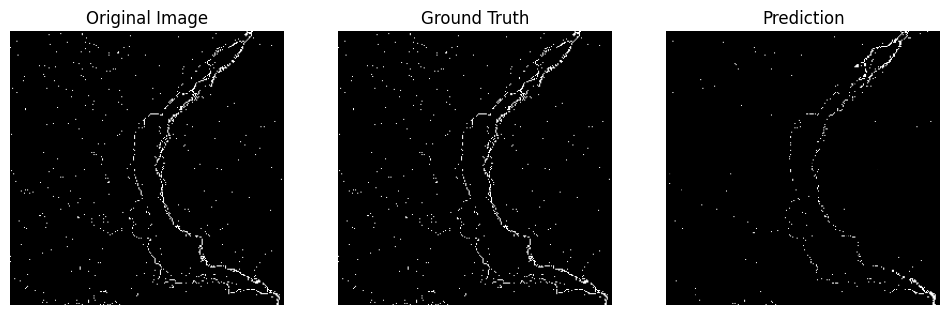

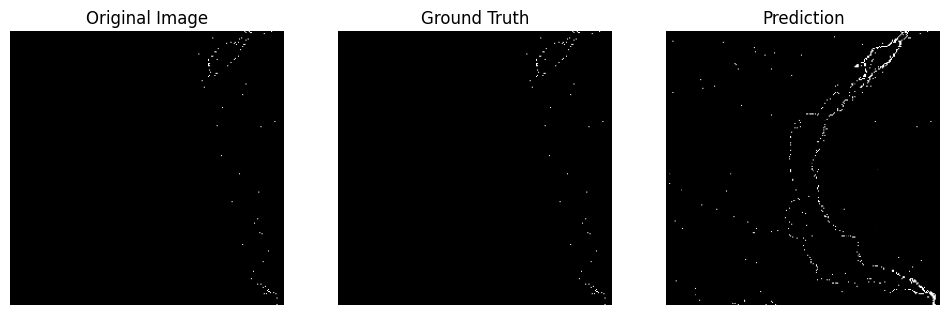

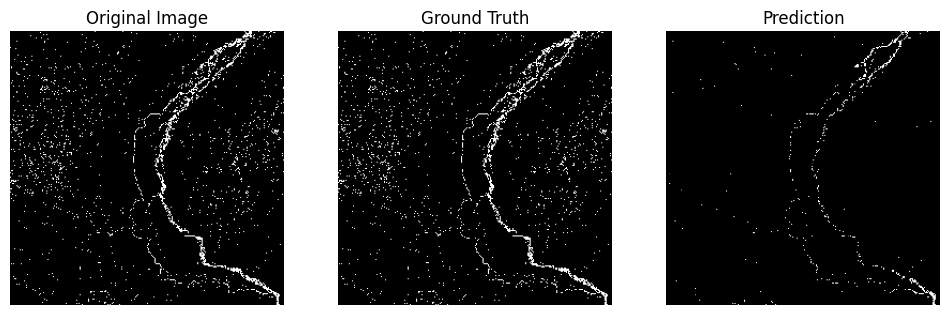

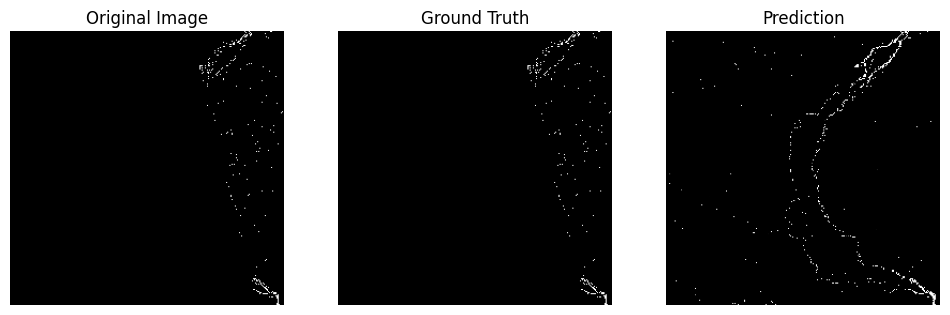

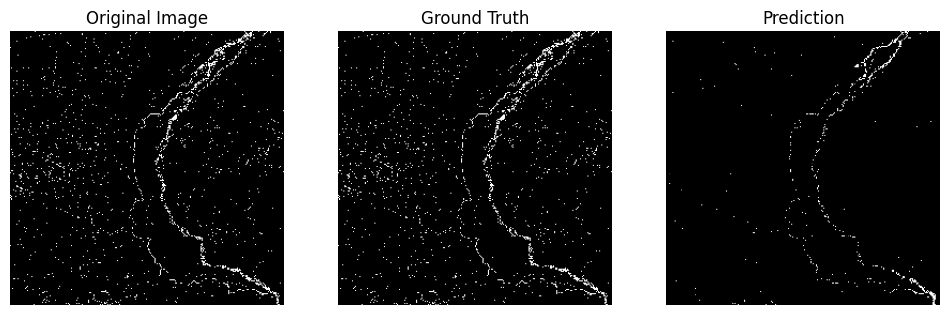

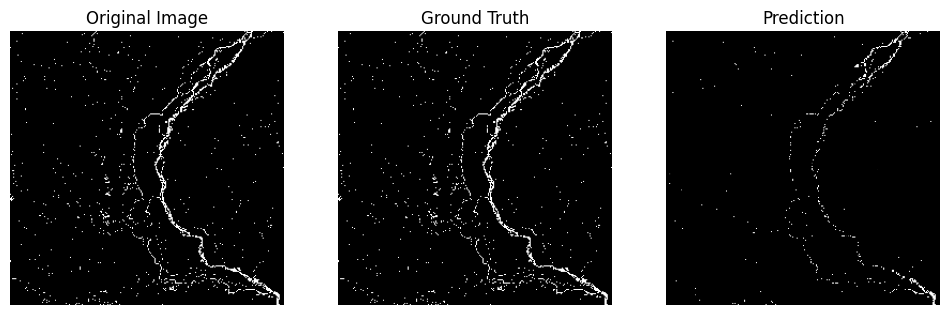

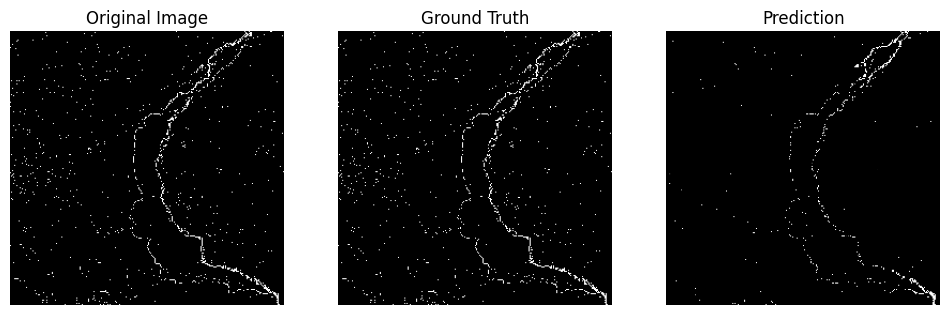

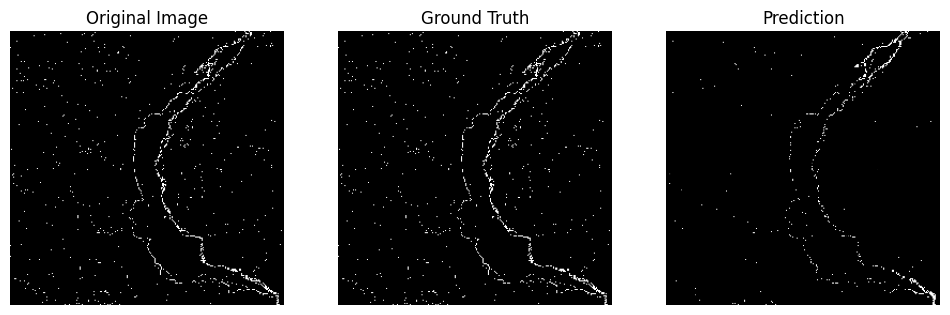

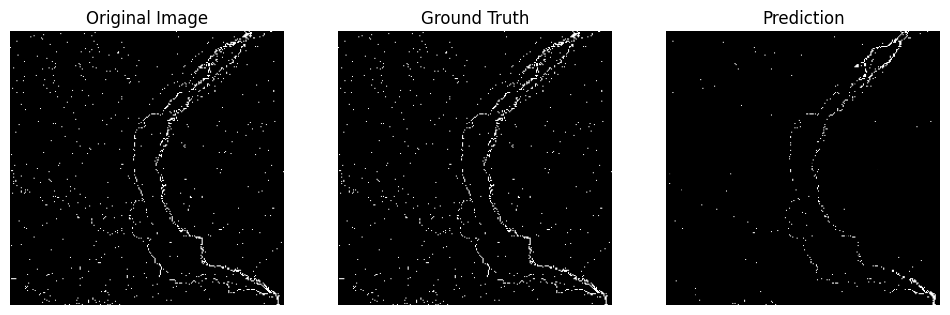

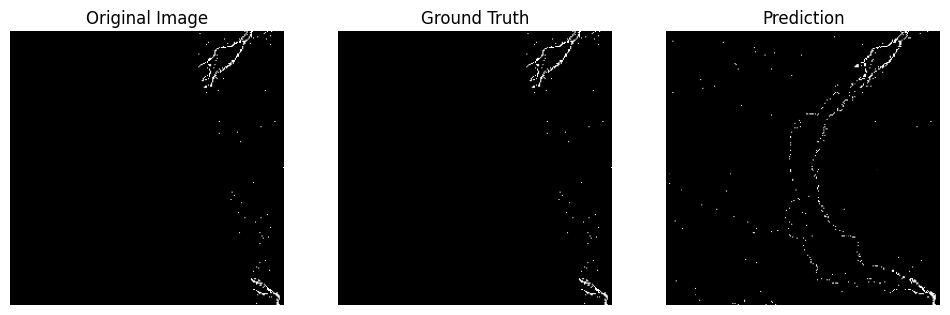

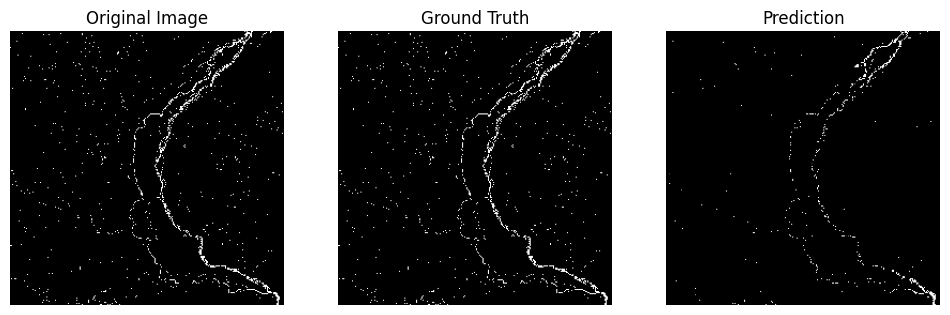

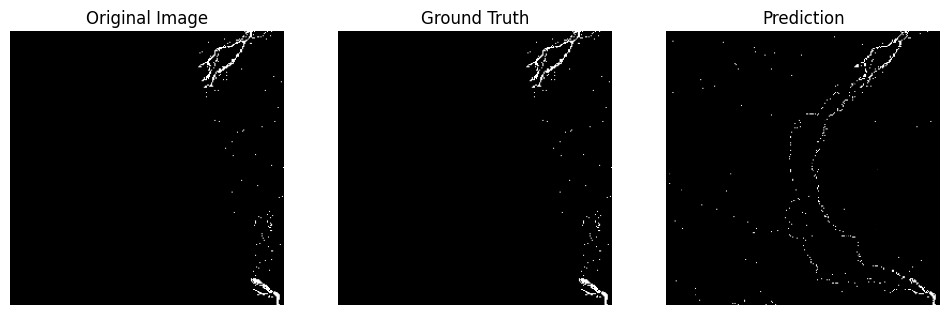

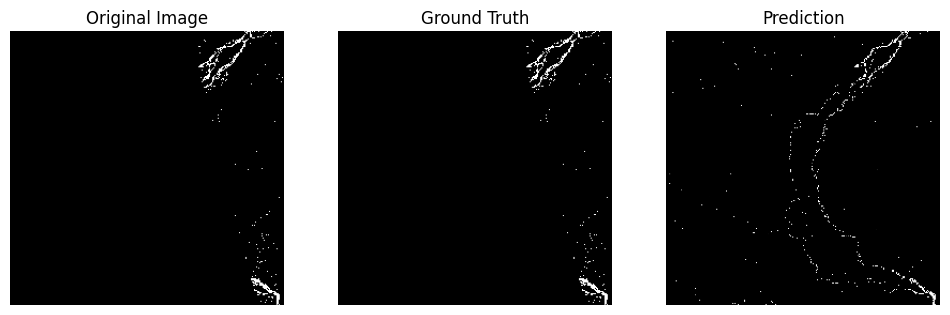

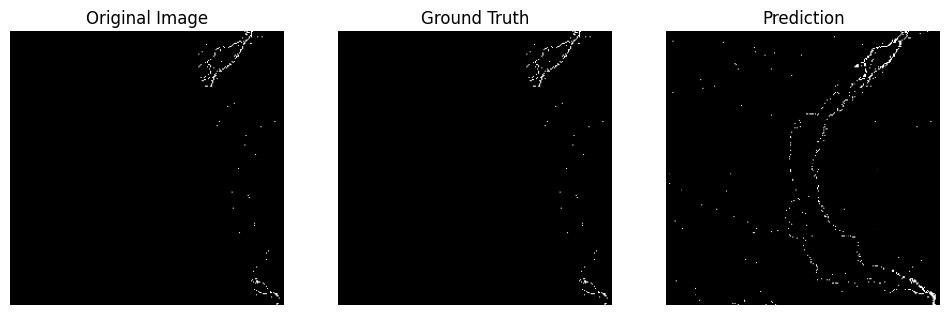

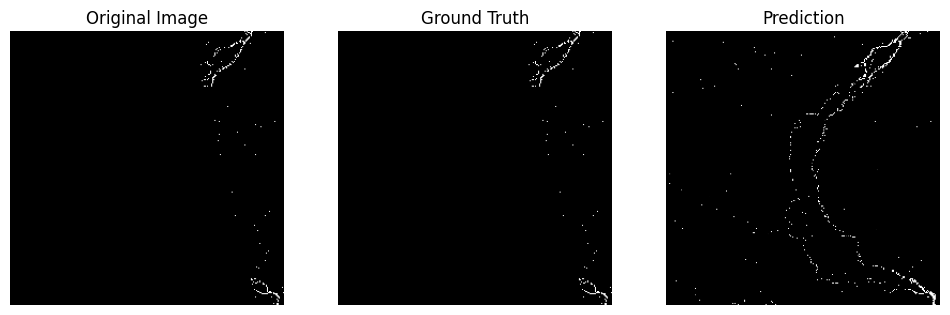

In [30]:
# Plot some sample results
num_samples_to_plot = 15
for i in range(num_samples_to_plot):
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test_img[i].reshape(256, 256), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Ground truth
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i].reshape(256, 256), cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred[i].reshape(256, 256), cmap='gray')
    plt.title('Prediction')
    plt.axis('off')

    plt.show()

NameError: name 'y_pred_images' is not defined

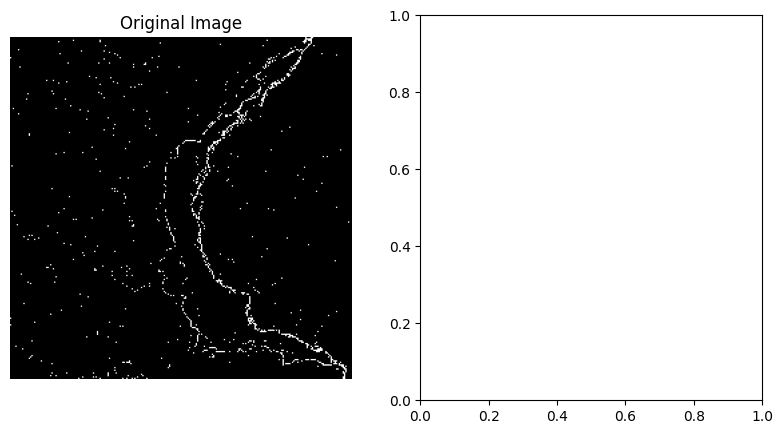

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_test_params and y_pred_params are multi-dimensional
# Flatten or select a specific slice for plotting
def flatten_or_select(data, index):
    if len(data.shape) > 1:
        return data[index].flatten()  # Flatten the selected data
    return data

num_samples = 5  # Number of samples to visualize
for i in range(num_samples):
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test_img[i].reshape(256, 256), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Predicted Image
    plt.subplot(1, 3, 2)
    plt.imshow(y_pred_images[i].reshape(256, 256), cmap='gray')
    plt.title('Predicted Image')
    plt.axis('off')

    # Parameters
    plt.subplot(1, 3, 3)
    original_params = flatten_or_select(y_test_params, i)
    predicted_params = flatten_or_select(y_pred_params, i)
    plt.plot(original_params, label='Original')
    plt.plot(predicted_params, '--', label='Predicted')
    plt.title('Parameters')
    plt.legend()

    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate and display some sample predictions
num_samples = 17  # Number of samples to display
for i in range(num_samples):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display original image
    axes[0].imshow(X_test_img[i].reshape(256, 256), cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Display predicted image
    axes[1].imshow(y_pred_images[i].reshape(256, 256), cmap='gray')
    axes[1].set_title('Predicted Image')
    axes[1].axis('off')

    # Display the original and predicted parameter values
    # Make sure the parameters are flattened if they have extra dimensions
    if y_test_params[i].ndim > 1:
        y_test_params_flat = y_test_params[i].flatten()
    else:
        y_test_params_flat = y_test_params[i]

    if y_pred_params[i].ndim > 1:
        y_pred_params_flat = y_pred_params[i].flatten()
    else:
        y_pred_params_flat = y_pred_params[i]

    axes[2].plot(y_test_params_flat, label='Original')
    axes[2].plot(y_pred_params_flat, '--', label='Predicted')
    axes[2].set_title('Parameters')
    axes[2].legend()

    plt.show()
